# 3 Sentiment analysis

For the predictive model I use pretrained bidirectional transformer [BERT](https://huggingface.co/transformers/model_doc/bert.html).

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import seaborn as sns

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn import metrics


sns.set(font_scale=2)


model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels= 5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

plt.style.use('seaborn-white')
%matplotlib inline

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


## 3.1 Reproducing Validation set
The data analysis performed for the current project will use only validation subset of the initial dataset.
The validation subset with over 75k rows is quite large  for illustrative purposes.
Since it has not been used neither for model training nor for tuning the model meta parameters,
it should give results similar to real serving case. I split the dataset into train (80% samples) and validation (20%) sets exactly the same way as it have been don in the training step: 

Loading clean and deduplicated dataset:

In [5]:
df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip",
                       compression="zip", index_col=0)

Transform review score to 0-based: from 1-5 stars to 0-4 label and rename column for clarity:

In [6]:
df_dedup["Score"] = df_dedup["Score"] - 1
df_dedup.rename(columns={"Score": "Label"}, inplace=True)
df_dedup.tail(5)

,Text,Summary,Label,HelpfulnessNumerator,HelpfulnessDenominator
394998,these are sooooooooooooooooooooooooo delicious...,"yummy. yummy, yummy!",4,0,3
394999,this is a for the price of review because p...,pure chocolate mallomars cookies,3,0,0
395000,this would be a great coffee drink to grab out...,soso espresso style coffee drink,2,1,2
395001,"earths best infant formula soy iron,ounce is a...",earths best soy baby formula,4,0,0
395002,taste. i was expecting it to taste pretty clos...,ehh okay i guess.,1,1,1


In [7]:
df_train = df_dedup.sample(frac=0.8,random_state=123)
df_test = df_dedup.drop(df_train.index)

## 3.2 Score prediction

Now using the trained model I can make *Score* predictions and analyze initial review data.
For serving the model the weights for trained model are read from file:

In [ ]:
model.load_weights("./amazon_my_trained_FL_G_e3x3vac77")

### 3.1.1 *Score* prediction based on review text

First the review scores will be predicted based on review texts.
For efficient batch serving of the BERT model the dataset samples should be converted to the *InputExample* objects, containing

- *guid* - unique id for the example (not used)
- *text_a* (string) - the untokenized text of the first sequence
- *text_b* (optional, string) - the untokenized text of the second sequence (not used)
- label (optional, int) - The label of the example

and assembled to the TensorFlow datasets the same way as it was done on the training stage:

In [ ]:
def convert_data_to_examples(df_input, data_column, label_column):
    input_examples = df_input.apply(lambda x:
                                    InputExample(guid=None,
                                                 text_a=x[data_column],
                                                 text_b=None,
                                                 label=x[label_column]),
                                    axis=1)
    return input_examples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,  # Adds [CLS] and [SEP].
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length",
            truncation=True)
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"], input_dict["token_type_ids"],
            input_dict['attention_mask'])
        features.append(InputFeatures(
            input_ids=input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids, label=e.label))

    def gen():
        for f in features:
            yield ({
                "input_ids": f.input_ids,
                "attention_mask": f.attention_mask,
                "token_type_ids": f.token_type_ids, },
                f.label, )
    return tf.data.Dataset.from_generator(
        gen, ({
            "input_ids": tf.int32,
            "attention_mask": tf.int32,
            "token_type_ids": tf.int32},
            tf.int64),
        ({
            "input_ids": tf.TensorShape([None]),
            "attention_mask": tf.TensorShape([None]),
            "token_type_ids": tf.TensorShape([None]), },
            tf.TensorShape([]), ), )

In [ ]:
validation_input_examples = convert_data_to_examples(
    df_test, "Text", "Label")
validation_data = convert_examples_to_tf_dataset(
    list(validation_input_examples), tokenizer)
validation_data = validation_data.batch(32)

The following (commented) code chunk used for the batch prediction on the Google Colab GPU runtime: 

In [ ]:
#tf_outputs = model.predict(validation_data)
#predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
#max_predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(max_predictions).to_csv("./drive/My Drive/Bert/PredVa79ke3x3.csv.zip", compression="zip")

The prediction results are read from file:

In [17]:
text_predictions = pd.read_csv("./PredVa79ke3x3.csv.zip",
                               index_col=0, compression="zip")

Functions for accuracy calculation and visualization of confusion matrix:

In [22]:
LABELS = ['Very Negative','Negative','Neutral','Positive','Very Positive']


def accuracy_print(conf_matrix):
    values = conf_matrix.view()
    error_count = values.sum() - np.trace(values)
    accuracy = 1.0 - error_count/len(df_test["Label"])
    print("accuracy for {0}-element subset is {1}.".format(
        len(df_test["Label"]), accuracy))
    
    
def plot_conf_mat(conf_matrix, title, xlabel, ylabel):
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, norm=clrs.LogNorm(), xticklabels=LABELS,
    yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
    plt.title(title, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()

The model confusion matrix for the validation set is following: 

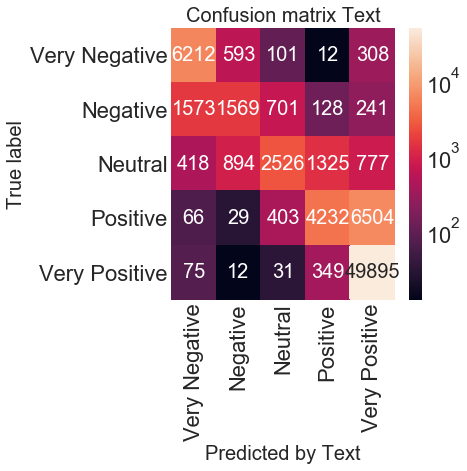

accuracy for 78974-element subset is 0.8158887735203991.


In [24]:
confusion_matrix = metrics.confusion_matrix(df_test["Label"], text_predictions)
plot_conf_mat(confusion_matrix, "Confusion matrix Text",
              "Predicted by Text", "True label")
accuracy_print(confusion_matrix)

One can see that majority of misclassified elements have neighboring score.
However a substantial number of *Very Negative* samples were missclassified as *Very Positive*.
Let's take a look at these samples:

In [13]:
#bad_as_good = df_test["Text"].iloc[
#    (text_predictions==4)&(df_test["Label"]==0)].tolist()

In [14]:
#print(BadAsGood[0])

In [15]:
#print(bad_as_good[1])

In [16]:
#print(bad_as_good[2])

In [17]:
#print(bad_as_good[3])

It looks like the model learned very expressive reviews as very positive. Another source of errors could be very long reviews containing many points with different sentiment.  

## 3.3 Sentiment correlation between review summary and text 

In [18]:
val_summary_input_examples = convert_data_to_examples(
    df_test, "Summary", "Label")
val_summary_data = convert_examples_to_tf_dataset(
    list(val_summary_input_examples), tokenizer)
val_summary_data = val_summary_data.batch(32)

ValueError: Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

In [ ]:
#tf_sum_outputs = model.predict(val_summary_data)
#sum_predictions = tf.nn.softmax(tf_sum_outputs[0], axis=-1)
#sum_max_predictions = np.argmax(sum_predictions, axis=1)
#pd.DataFrame(sum_max_predictions).to_csv("./drive/My Drive/Bert/PredSumVa79ke3x3.csv.zip", compression="zip")

In [ ]:
sum_predictions = pd.read_csv("./PredSumVa79ke1x12.zip", index_col=0, compression="zip")

In [ ]:
confusion_matrix_sum = metrics.confusion_matrix(text_predictions, sum_predictions)
confusion_matrix_sum_text = metrics.confusion_matrix(df_test["Label"], sum_predictions)

In [ ]:
plt.figure(figsize=(5, 5))

sns.heatmap(confusion_matrix_sum, norm=clrs.LogNorm(), xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix Summary", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted by Summary', fontsize=20)
plt.show()

accuracy_print(confusion_matrix_sum)

In [ ]:
plt.figure(figsize=(5, 5))

sns.heatmap(confusion_matrix_sum_text, norm=clrs.LogNorm(), xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix Summary/Text", fontsize=20)
plt.ylabel("Predicted by Text", fontsize=20)
plt.xlabel("Predicted by Summary", fontsize=20)
plt.show()

accuracy_print(confusion_matrix_sum_text)

The sentiment of Summary and Text is generally aligned. Let's inspect the cases the samples with extreme missalignment:    

In [ ]:
badtext_goodsum = df_test[["Text", "Summary", "Score"]][0:text_predictions.size].loc[
    (text_predictions==0)&(sum_predictions==4)]
goodtext_badsum = df_test[["Text", "Summary", "Score"]][0:text_predictions.size].loc[
    (text_predictions==4)&(sum_predictions==0)]

In [ ]:
def print_text_sum_pred(text_pred, sum_pred, index):
    df_cmp = df_test[["Text", "Summary", "Score"]][0:text_predictions.size].loc[
    (text_predictions==text_pred)&(sum_predictions==sum_pred)]
    print(df_cmp.iloc[[index]]["Text"].tolist(), 
          df_cmp.iloc[[index]]["Summary"].tolist(), 
          df_cmp.iloc[[index]]["Score"])

In [ ]:
print_text_sum_pred(0, 4, 2)

In [ ]:
print_text_sum_pred(0, 4, 4)

In [ ]:
print_text_sum_pred(4, 0, 2)

In [ ]:
print_text_sum_pred(4, 0, 4)

The examples above shows that Summary and Text missalignment appears usually if one of the fields (Text or Summary) is very hard to classify due to lack of useful tokens in very short summary or excessive size of the review Text, containing sentences with various sentiment.

In [19]:
df_dedup.iloc[509]

Text                      NaN
Summary                      
Label                       4
HelpfulnessNumerator        1
HelpfulnessDenominator      2
Name: 509, dtype: object

In [6]:
df_dedup.isna().sum()

Text                        1
Summary                   133
Score                       0
HelpfulnessNumerator        0
HelpfulnessDenominator      0
dtype: int64